In [1]:
import gc
import glob
import utils
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from os import makedirs
from util.path import derivpath
from scipy.spatial.distance import cdist
from util.plot import formatim, formatenc
from utils import load_pickle
from sklearn.decomposition import PCA

plt.style.use("presentation.mplstyle")
colors = sns.color_palette()
RED, BLUE = colors[3], colors[0]
YELLOW, GRAY = "goldenrod", colors[7]  # goldenrod: 218., 165.,  32.
RED_CMAP = sns.light_palette(RED, as_cmap=True)
BLUE_CMAP = sns.light_palette(BLUE, as_cmap=True)
fs1c = (2.24, 2.24 / (4 / 3))
fs2c = (4.76, 4.76 / (4 / 3))
fs3c = (7.24, 7.24 / (4 / 3))
gr = 1 - np.sqrt(5) / 2 + 0.5

In [35]:
# Options
root = "../dataset/derivatives/encoding/"
# root = "../dataset/derivatives/encoding_bands/"
Ss = [1, 2, 3, 4, 5, 6, 9, 10, 11, 12]
modes = ["prod", "comp"]

modelname = 'model-gpt2-xl_maxlen-1024_layer-24_reg-l2'
# modelname = 'model-gpt2-xl-300d_maxlen-1024_layer-24_reg-l2'
# modelname = 'model-glove-300_reg-l2'
modelname

'model-gpt2-xl_maxlen-1024_layer-24_reg-l2'

## generate PCA'd embeddings
for revision

In [ ]:
# joint PCA all embeddings
embs = []
for sub in Ss[::2]:
    filename = f'../dataset/derivatives/embeddings/sub-{sub:02d}/gpt2-xl/sub-{sub:02d}_task-conversation_model-gpt2-xl_maxlen-1024_layer-24_embeddings.pkl'
    df = pd.read_pickle(filename)
    print(sub, len(df))
    embs.append(np.vstack(df.embedding.values))
embs = np.vstack(embs)
print(embs.shape)

pca = PCA(n_components=300).fit(embs)

1 4545
3 4056
5 3644
9 4409
11 7526
(24180, 1600)


In [ ]:
for sub in Ss:
    filename = f'../dataset/derivatives/embeddings/sub-{sub:02d}/gpt2-xl/sub-{sub:02d}_task-conversation_model-gpt2-xl_maxlen-1024_layer-24_embeddings.pkl'
    df = pd.read_pickle(filename)
    embeddings = np.vstack(df.embedding.values)
    new_embs = pca.transform(embeddings)
    print(sub, embeddings.shape, new_embs.shape)
    df['embedding'] = [e for e in new_embs]
    filename = f'../dataset/derivatives/embeddings/sub-{sub:02d}/gpt2-xl-300d/sub-{sub:02d}_task-conversation_model-gpt2-xl-300d_maxlen-1024_layer-24_embeddings.pkl'
    makedirs(f'../dataset/derivatives/embeddings/sub-{sub:02d}/gpt2-xl-300d', exist_ok=True)
    df.to_pickle(filename)

1 (4545, 1600) (4545, 300)
2 (4546, 1600) (4546, 300)
3 (4056, 1600) (4056, 300)
4 (4056, 1600) (4056, 300)
5 (3644, 1600) (3644, 300)
6 (3644, 1600) (3644, 300)
9 (4409, 1600) (4409, 300)
10 (4409, 1600) (4409, 300)
11 (7526, 1600) (7526, 300)
12 (7526, 1600) (7526, 300)


# load data

In [18]:
results = {}

In [33]:
# Load actual results
def load_model_results(modelname):
    for sub in Ss:
        for mode in modes:
            filename = f"{root}sub-{sub:02d}/{modelname}/sub-{sub:02d}_task-conversation_encoding_mode-{mode}_band-highgamma_nfolds-2.pkl"
            # filename = f"{root}sub-{sub:02d}/{modelname}/sub-{sub:02d}_task-conversation_encoding_bands_mode-{mode}_band-highgamma_nfolds-2.pkl"
            actual_pickle = glob.glob(filename)
            if len(actual_pickle):
                print(sub, mode, modelname)
                with open(actual_pickle[0], "rb") as f:
                    result = pickle.load(f)
                    del result['embs']
                    del result['df']
                    del result["args"]
                    del result["preds"]
                    del result["true"]
                    results[(sub, mode, modelname)] = result
    gc.collect()

In [36]:
load_model_results(modelname)

1 prod model-gpt2-xl_maxlen-1024_layer-24_reg-l2
1 comp model-gpt2-xl_maxlen-1024_layer-24_reg-l2
2 prod model-gpt2-xl_maxlen-1024_layer-24_reg-l2
2 comp model-gpt2-xl_maxlen-1024_layer-24_reg-l2
3 prod model-gpt2-xl_maxlen-1024_layer-24_reg-l2
3 comp model-gpt2-xl_maxlen-1024_layer-24_reg-l2
4 prod model-gpt2-xl_maxlen-1024_layer-24_reg-l2
4 comp model-gpt2-xl_maxlen-1024_layer-24_reg-l2
5 prod model-gpt2-xl_maxlen-1024_layer-24_reg-l2
5 comp model-gpt2-xl_maxlen-1024_layer-24_reg-l2
6 prod model-gpt2-xl_maxlen-1024_layer-24_reg-l2
6 comp model-gpt2-xl_maxlen-1024_layer-24_reg-l2
9 prod model-gpt2-xl_maxlen-1024_layer-24_reg-l2
9 comp model-gpt2-xl_maxlen-1024_layer-24_reg-l2
10 prod model-gpt2-xl_maxlen-1024_layer-24_reg-l2
10 comp model-gpt2-xl_maxlen-1024_layer-24_reg-l2
11 prod model-gpt2-xl_maxlen-1024_layer-24_reg-l2
11 comp model-gpt2-xl_maxlen-1024_layer-24_reg-l2
12 prod model-gpt2-xl_maxlen-1024_layer-24_reg-l2
12 comp model-gpt2-xl_maxlen-1024_layer-24_reg-l2


In [37]:
# make sure there were only 2 folds
len(results[(1, 'prod', modelname)]['corrs'])

2

In [38]:
method, alpha = "fdr_bh", 0.01
datatype = f"method-{method}_alpha-{alpha}_lags-1"
sigmodelname = "model-gpt2-xl_maxlen-0_reg-l2_perm-phase"
p = derivpath(
    f"sub-all_model-{sigmodelname}.pkl",
    derivative="electrode-selection",
    datatype=datatype,
)
sigmasks = load_pickle(p)
sigmasks = {key[:2]: value for key, value in sigmasks.items()}
nsig_elecs = sum([s.sum() for s in sigmasks.values()])
nsig_elecs, sigmasks.keys()

(384,
 dict_keys([(1, 'prod'), (1, 'comp'), (2, 'prod'), (2, 'comp'), (3, 'prod'), (3, 'comp'), (4, 'prod'), (4, 'comp'), (5, 'prod'), (5, 'comp'), (6, 'prod'), (6, 'comp'), (9, 'prod'), (9, 'comp'), (10, 'prod'), (10, 'comp'), (11, 'prod'), (11, 'comp'), (12, 'prod'), (12, 'comp')]))

# extract results

In [39]:
tmax, window, jump = 4, 0.250, 0.03125 * 2
lags = np.arange(-tmax, tmax + jump, jump)

In [40]:
prod_sub_results = []
comp_sub_results = []

for sub in Ss:
    for mode, result in zip(modes, (prod_sub_results, comp_sub_results)):
        mask = sigmasks[(sub, mode)]
        result.append(np.stack(results[(sub, mode, modelname)]['corrs']).mean(0)[mask])

prod_avg_results = np.vstack(prod_sub_results).mean(0)
comp_avg_results = np.vstack(comp_sub_results).mean(0)

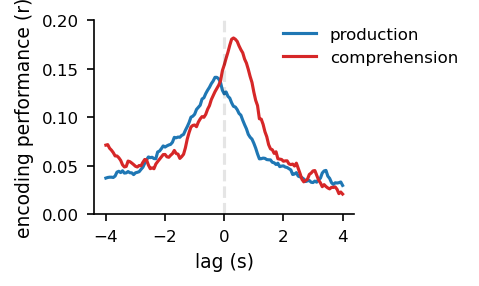

In [41]:
fig, ax = plt.subplots()

ax.plot(lags, prod_avg_results, c=BLUE, label='production')
ax.plot(lags, comp_avg_results, c=RED, label='comprehension')
formatenc(ax)

ax.set(xlabel="lag (s)", ylabel="encoding performance (r)", ylim=(0, .2))
ax.legend(frameon=False, loc="upper left", bbox_to_anchor=(.7, 1), borderaxespad=0.0)

fig.show()

# compute similarity

In [42]:
def weights_2f(subA, subB=None):
    subB = utils.getpartner(subA) if subB is None else subB

    coefsA = results[(subA, "prod", modelname)]["coefs"][0]
    coefsB = results[(subB, "comp", modelname)]["coefs"][1]

    sigA = sigmasks[(subA, "prod")]
    sigB = sigmasks[(subB, "comp")]

    coefsA = coefsA[:, sigA].mean(1)
    coefsB = coefsB[:, sigB].mean(1)

    # print(np.isnan(coefsB).any())

    C = 1 - cdist(coefsA.T, coefsB.T, metric="correlation")
    return C

In [43]:
M1 = np.stack([weights_2f(sub) for sub in Ss])
M1 = M1.mean(0)
M1.min(), M1.max()

(-0.06601082952949308, 0.10184895140460845)

In [44]:
null_distribution = []
for s in Ss:
    part = utils.getpartner(s)
    for p in Ss:
        if p != s and p != part:
            null_distribution.append(weights_2f(s, p))

M2 = np.mean(null_distribution, 0)
M2.shape, M2.max()

((129, 129), 0.0671628404937355)

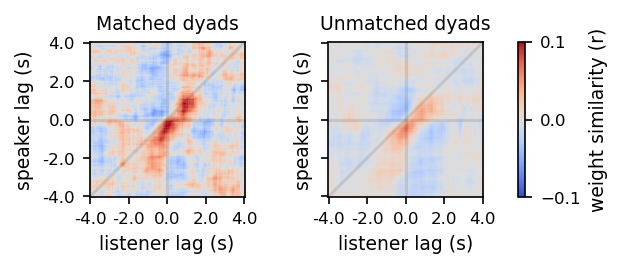

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(4.2, 1.68), sharex=True, sharey=True, layout="constrained")

mx = 0.1

ax = axes[0]
im = ax.imshow(M1, origin="lower", interpolation=None, cmap="coolwarm", vmin=-mx, vmax=mx, aspect="equal",)
formatim(fig, ax, im, lags, cbar_loc=None)
ax.set(xlabel="listener lag (s)", ylabel="speaker lag (s)", title="Matched dyads")

ax = axes[1]
im = ax.imshow(M2, origin="lower", interpolation=None, cmap="coolwarm", vmin=-mx, vmax=mx, aspect="equal",)
formatim(fig, ax, im, lags, cbar_loc=None)
ax.set(xlabel="listener lag (s)", ylabel="speaker lag (s)", title="Unmatched dyads")

cbar = fig.colorbar(im, ax=axes)
cbar.ax.set_ylabel("weight similarity (r)")
cbar.set_ticks([im.get_clim()[0], 0, im.get_clim()[-1]])

plt.show()

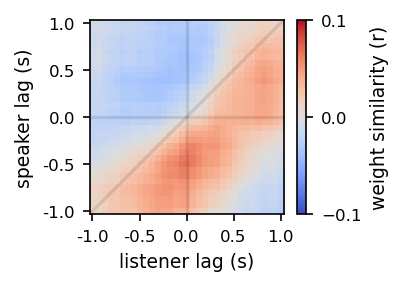

In [46]:
fig, ax = plt.subplots()
mx = .1
# Z = np.zeros_like(M2[48:81, 48:81])
im = ax.imshow(M2[48:81, 48:81], origin="lower", interpolation=None, cmap="coolwarm", vmin=-mx, vmax=mx, aspect="equal",)
formatim(fig, ax, im, lags[48:81], cbar_loc=None)
ax.set(xlabel="listener lag (s)", ylabel="speaker lag (s)")

cbar = fig.colorbar(im, ax=ax)
cbar.ax.set_ylabel("weight similarity (r)")
cbar.set_ticks([im.get_clim()[0], 0, im.get_clim()[-1]])

fig.show()

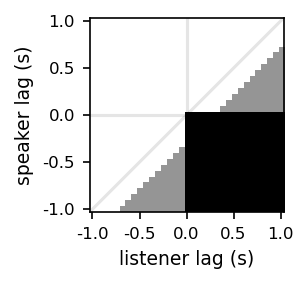

In [77]:
fig, ax = plt.subplots()
Z = np.zeros_like(M2[48:81, 48:81])
Z[np.triu_indices(len(Z), 5)] = 0.5
Z[:17, 16:] = 1
im = ax.imshow(Z, origin="lower", interpolation=None, cmap="Greys", vmin=0, vmax=1, aspect="equal",)
formatim(fig, ax, im, lags[48:81], cbar_loc=None)
ax.set(xlabel="listener lag (s)", ylabel="speaker lag (s)")

fig.show()

In [47]:
# m2_model_compare = {}
m2_model_compare[modelname] = M2
m2_model_compare.keys()

dict_keys(['model-glove-300_reg-l2', 'model-gpt2-xl-300d_maxlen-1024_layer-24_reg-l2', 'model-gpt2-xl_maxlen-1024_layer-24_reg-l2'])

In [48]:
model_order = ['model-gpt2-xl_maxlen-1024_layer-24_reg-l2', 'model-gpt2-xl-300d_maxlen-1024_layer-24_reg-l2', 'model-glove-300_reg-l2']

In [80]:
def extract_square_triangle(X):
    X = X[48:81, 48:81]
    m = X.shape[0]
    r,c = np.triu_indices(m, 0)
    return X[r,c].ravel()

In [74]:
def extract_quad(X):
    X = X[48:81, 48:81]
    return X[:17, 16:].ravel()

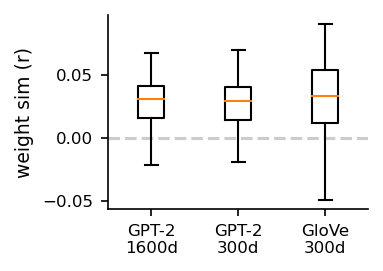

In [81]:
# plt.boxplot([extract_quad(m2_model_compare[m]) for m in model_order], meanline=True, showfliers=False)
plt.boxplot([extract_square_triangle(m2_model_compare[m]) for m in model_order], meanline=True, showfliers=False)
plt.axhline(0, c='k', alpha=0.2, ls='--')
plt.xticks(range(1, 4), ['GPT-2\n1600d', 'GPT-2\n300d', 'GloVe\n300d'])
plt.ylabel('weight sim (r)')
plt.show()